# Investigating a linear relationships between fire arm possession, homicides by fire arms, and mass shootings for different countries while also considering the country's GDP

# 1. DATA: 

[Link](https://github.com/fedhere/PUI2018_fb55/blob/master/HW9_fb55/World%20firearms%20murders%20and%20ownership%20-%20Sheet%201.csv) to the Guardian firearms murders and ownership data in 2012

[Link](https://datawrapper.dwcdn.net/pvLFI/4/) to the number of mass shootings

[Link](https://data.worldbank.org/indicator/SP.POP.TOTL) to the world population by country 

In [ ]:
__author__ = 'Solution by Linda Jaber, CUSP NYU 2018, Principles of Urban Informatics'
from __future__ import print_function

import sys
import os
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    
import pandas as pd

import matplotlib.pyplot as plot

import scipy as sp
from scipy import optimize

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from IPython.display import Image

%pylab inline

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [ ]:
# Setting the environment for downloads
PUIdata = os.getenv('PUIDATA')
if PUIdata is None:
    os.environ['PUIDATA']='%s/PUIdata'%os.getenv('HOME')
    PUIdata = os.getenv('PUIDATA')
print('PUIdata: ', PUIdata) 

### Downloading Data

In [3]:
# firearms murders and ownership data

!wget https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW9_fb55/World%20firearms%20murders%20and%20ownership%20-%20Sheet%201.csv
%mkdir $PUIDATA/HW_9
!mv 'World firearms murders and ownership - Sheet 1.csv' $PUIDATA/HW_9

In [4]:
# Number of mass shootings data

url = 'data:application/octet-stream;charset=utf-8,Country%2CGuns%20per%20100%20inhabitants%2CNumber%20of%20mass%20shootings%20(1983-2013)%0AAustralia%2C15%2C4%0AAustria%2C30.4%2C1%0ABelgium%2C17.2%2C2%0ACanada%2C30.8%2C4%0ADenmark%2C12%2C0%0AFinland%2C45.3%2C2%0AFrance%2C31.2%2C6%0AGermany%2C30.3%2C7%0AGreece%2C22.5%2C0%0AHolland%2C3.9%2C2%0AHungary%2C5.5%2C0%0AIceland%2C30.3%2C0%0AIreland%2C8.6%2C0%0AItaly%2C11.9%2C0%0AJapan%2C0.6%2C0%0ALuxembourg%2C15.3%2C0%0ANew%20Zealand%2C22.6%2C3%0ANorway%2C31.3%2C1%0APoland%2C1.3%2C0%0APortugal%2C8.5%2C1%0ASpain%2C10.4%2C1%0ASweden%2C31.6%2C2%0ASwitzerland%2C45.7%2C2%0AUnited%20Kingdom%2C6.2%2C3%0AUnited%20States%2C88.8%2C78'
urllib.urlretrieve(url, 'data-pvLFI.csv')
!mv data-pvLFI.csv $PUIDATA/HW_9

In [5]:
# the world population by country data

url = 'http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv'
urllib.urlretrieve(url, 'file.gz')
!unzip file.gz -d $PUIDATA/HW_9
!mv file.gz $PUIDATA/HW_9

In [ ]:
# the world gdp by country

url = 'http://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=csv'
urllib.urlretrieve(url, 'file2.gz')
!unzip file2.gz -d $PUIDATA/HW_9
!mv file2.gz $PUIDATA/HW_9
!ls -ltr $PUIDATA/HW_9

## Reading Data

In [7]:
df_ = pd.read_csv(PUIdata + '/HW_9/World firearms murders and ownership - Sheet 1.csv',\
                  usecols=['Country/Territory', 'Average total all civilian firearms', 'Number of homicides by firearm'])
df_.columns = ['Country Name', 'Number of homicides by firearm', 'Average total all civilian firearms',]
df_.head()

,Country Name,Number of homicides by firearm,Average total all civilian firearms
0,Albania,56.0,270000.0
1,Algeria,20.0,1900000.0
2,Angola,NaN,2800000.0
3,Anguilla,1.0,NaN
4,Argentina,1198.0,3950000.0


In [8]:
df_ms = pd.read_csv(PUIdata + '/HW_9/data-pvLFI.csv')
df_ms.columns = ['Country Name', 'Guns/100 inhabitants', 'Number of mass shootings']
df_ms.head()

,Country Name,Guns/100 inhabitants,Number of mass shootings
0,Australia,15.0,4
1,Austria,30.4,1
2,Belgium,17.2,2
3,Canada,30.8,4
4,Denmark,12.0,0


In [9]:
# took year 2012 as it is the year mentioned for the Guardian data
df_pop = pd.read_csv(PUIdata + '/HW_9/API_SP.POP.TOTL_DS2_en_csv_v2_10203548.csv', skiprows=[0], header=1, usecols=['Country Name', '2012'])
df_pop.columns = ['Country Name', 'pop']
df_pop.head()

,Country Name,pop
0,Aruba,102577.0
1,Afghanistan,30696958.0
2,Angola,25096150.0
3,Albania,2900401.0
4,Andorra,82431.0


In [10]:
df_gdp = pd.read_csv(PUIdata + '/HW_9/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10203569.csv', skiprows=[0], header=1, usecols=['Country Name', '2012'])
df_gdp.columns = ['Country Name', 'gdp']
df_gdp.head()

,Country Name,gdp
0,Aruba,NaN
1,Afghanistan,2.053654e+10
2,Angola,1.139232e+11
3,Albania,1.231978e+10
4,Andorra,3.164615e+09


In [11]:
df = df_pop.merge(df_gdp, on='Country Name').merge(df_, on='Country Name').merge(df_ms, on='Country Name')
df.head()

,Country Name,pop,gdp,Number of homicides by firearm,Average total all civilian firearms,Guns/100 inhabitants,Number of mass shootings
0,Australia,22742475.0,1.543411e+12,30.0,3050000.0,15.0,4
1,Austria,8429991.0,4.094252e+11,18.0,2500000.0,30.4,1
2,Belgium,11128246.0,4.978842e+11,70.0,1800000.0,17.2,2
3,Canada,34750545.0,1.824289e+12,173.0,9950000.0,30.8,4
4,Switzerland,7996861.0,6.680436e+11,57.0,3400000.0,45.7,2


In [12]:
df.shape

(23, 7)

# 2 Exploration

## 2.1 Plotting mass shooting vs gdp in absolute numbers, and per person. 

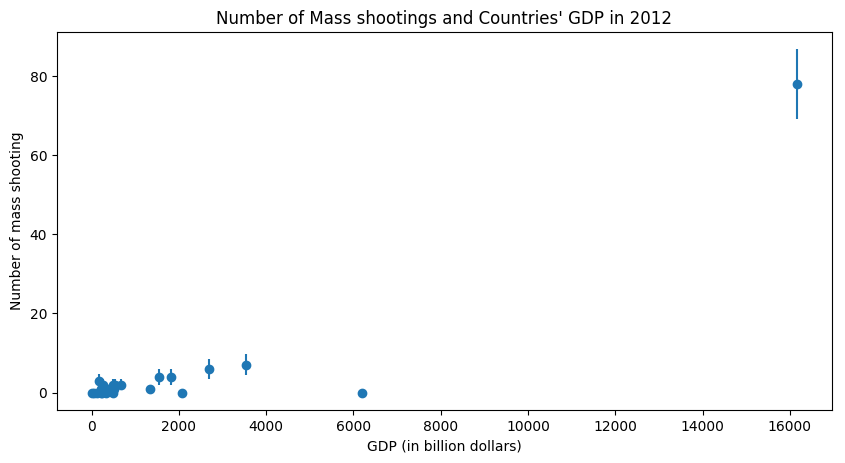

Number of mass shooting vs GDP, errors represent Poisson statistics.
The datapoint to the top right of the plot is the USA, which has the highest GDP and the highest number of mass shootings


In [13]:
fig = plt.figure(figsize=(10,5), dpi=100) 
ax = fig.add_subplot(111)

scatter = ax.scatter(df.gdp / 1e9, df['Number of mass shootings'])
ax.errorbar(df.gdp / 1e9, df['Number of mass shootings'], 
            yerr = np.sqrt(df['Number of mass shootings'] * 1.0), fmt = '.')

ax.set_xlabel("GDP (in billion dollars)")
ax.set_ylabel("Number of mass shooting")
ax.set_title("Number of Mass shootings and Countries' GDP in 2012")
ax.set_ylim()
plt.show()

print (color.BOLD + "Number of mass shooting vs GDP, " + 
       "errors represent Poisson statistics.\n" + 
       "The datapoint to the top right of the plot is the USA, " + 
       "which has the highest GDP and the highest number of mass shootings")


In [14]:
type(df['gdp'][0])

numpy.float64

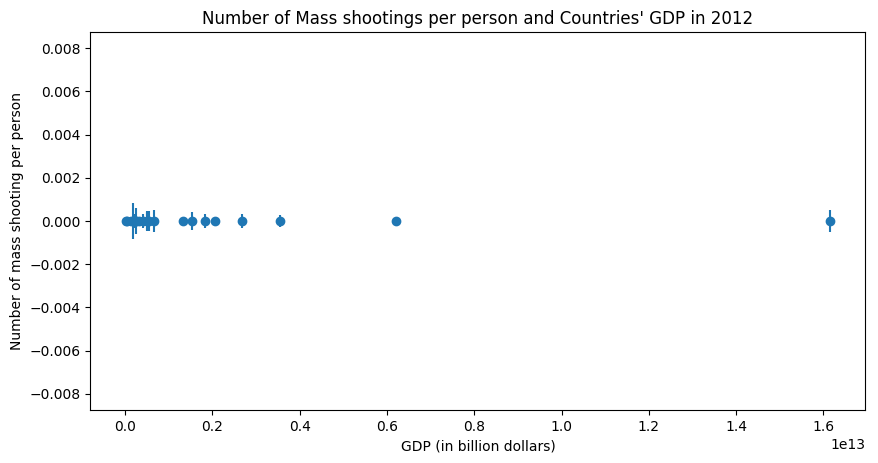

Number of mass shooting vs GDP per capita,errors represent Poisson statistics.
We notice that when plotting the number of mass shhoting per caapita the us is no longer an outlier


In [15]:
fig = plt.figure(figsize=(10,5), dpi=100) 
ax = fig.add_subplot(111)

scatter = ax.scatter(df['gdp'], df['Number of mass shootings'] / df['pop'])
ax.errorbar(df['gdp'], df['Number of mass shootings']/df['pop'], yerr=np.sqrt(df['Number of mass shootings']/df['pop']), fmt='.')

ax.set_xlabel("GDP (in billion dollars)")
ax.set_ylabel("Number of mass shooting per person")
ax.set_title("Number of Mass shootings per person and Countries' GDP in 2012")

ax.set_ylim()
plt.show()

print (color.BOLD + 'Number of mass shooting vs GDP per capita,\
errors represent Poisson statistics.\n\
We notice that when plotting the number of mass shhoting per caapita the us is no longer an outlier')


## 2.2 Plotting the average number of civilian fire arms per 1000 people

In [16]:
df['average number of civilian fire arms/1000 people'] = df['Average total all civilian firearms'] / df['pop'] * 1000
df.head()

,Country Name,pop,gdp,Number of homicides by firearm,Average total all civilian firearms,Guns/100 inhabitants,Number of mass shootings,average number of civilian fire arms/1000 people
0,Australia,22742475.0,1.543411e+12,30.0,3050000.0,15.0,4,134.110294
1,Austria,8429991.0,4.094252e+11,18.0,2500000.0,30.4,1,296.560222
2,Belgium,11128246.0,4.978842e+11,70.0,1800000.0,17.2,2,161.750558
3,Canada,34750545.0,1.824289e+12,173.0,9950000.0,30.8,4,286.326445
4,Switzerland,7996861.0,6.680436e+11,57.0,3400000.0,45.7,2,425.166825


In [17]:
df.tail()

,Country Name,pop,gdp,Number of homicides by firearm,Average total all civilian firearms,Guns/100 inhabitants,Number of mass shootings,average number of civilian fire arms/1000 people
18,New Zealand,4408100.0,1.761929e+11,7.0,925000.0,22.6,3,209.840975
19,Poland,38063164.0,5.003608e+11,35.0,510000.0,1.3,0,13.398781
20,Portugal,10514844.0,2.163682e+11,44.0,900000.0,8.5,1,85.593281
21,Sweden,9519374.0,5.438806e+11,37.0,2800000.0,31.6,2,294.136988
22,United States,313993272.0,1.615526e+13,9146.0,270000000.0,88.8,78,859.891036


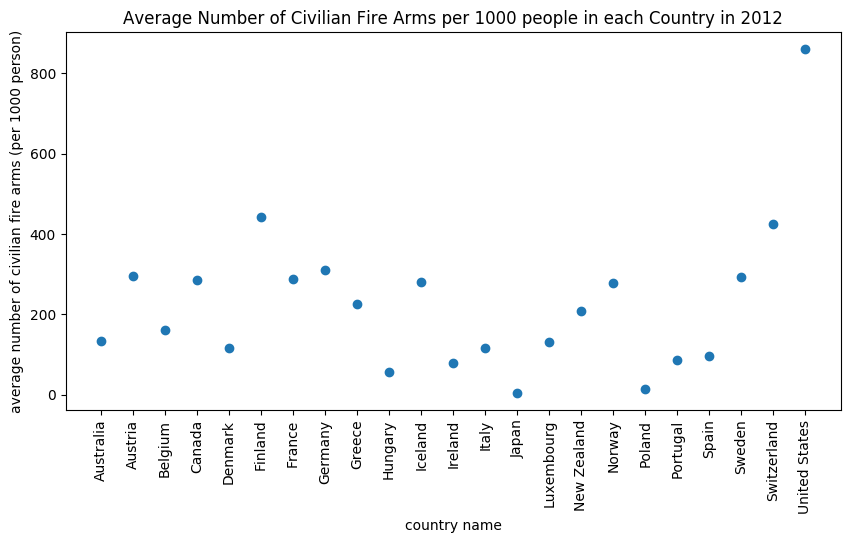

The average number of civilian fire arms per 1000 people plotted for each of the inspected countries.
Here again we can see how the United States represents an outlier with the highest average possesion of fire arms.
For every 1000 people in the United States almost 850 own a gun.


In [18]:
# plotting without error bars
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(df['Country Name'], df['average number of civilian fire arms/1000 people'], linestyle=' ', marker='o')

ax.set_xlabel('country name')
ax.set_ylabel('average number of civilian fire arms (per 1000 person)')
ax.set_title("Average Number of Civilian Fire Arms per 1000 people in each Country in 2012")
plt.xticks(rotation=90)
plt.show()

print(color.BOLD + 'The average number of civilian fire arms per 1000 people plotted for each of the inspected countries.\n\
Here again we can see how the United States represents an outlier with the highest average possesion of fire arms.\n\
For every 1000 people in the United States almost 850 own a gun.')

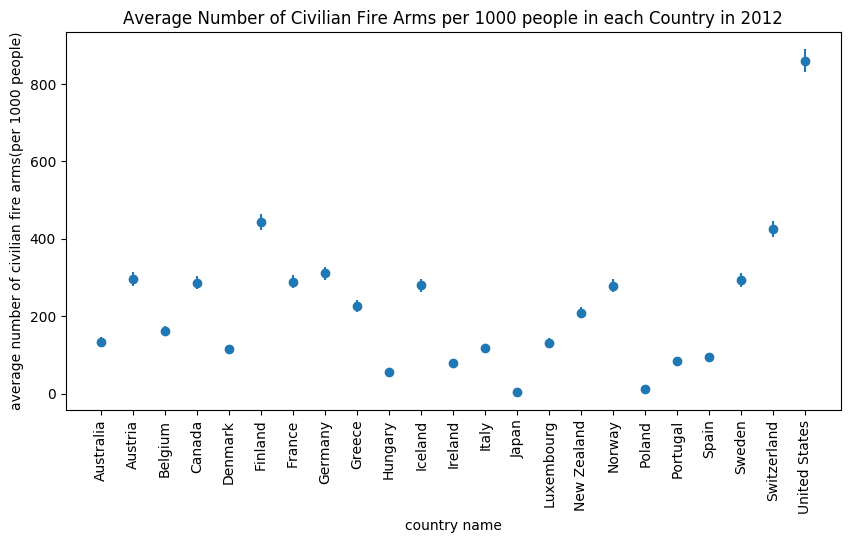

The average number of civilian fire arms per 1000 people plotted with errors for each of the inspected countries.
Here again we can see how the United States represents an outlier with the highest average possesion of fire arms.


In [19]:
# plotting with error bars
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.errorbar(df['Country Name'], df['average number of civilian fire arms/1000 people'],\
        yerr=np.sqrt(df['average number of civilian fire arms/1000 people']), linestyle=' ', marker='o')

ax.set_xlabel('country name')
ax.set_ylabel('average number of civilian fire arms(per 1000 people)')
ax.set_title("Average Number of Civilian Fire Arms per 1000 people in each Country in 2012")
plt.xticks(rotation=90)
plt.show()

print(color.BOLD + 'The average number of civilian fire arms per 1000 people plotted with errors for each of the inspected countries.\n\
Here again we can see how the United States represents an outlier with the highest average possesion of fire arms.')

## 2.3 Plotting the average number of homicide by fire arms per 1000 people

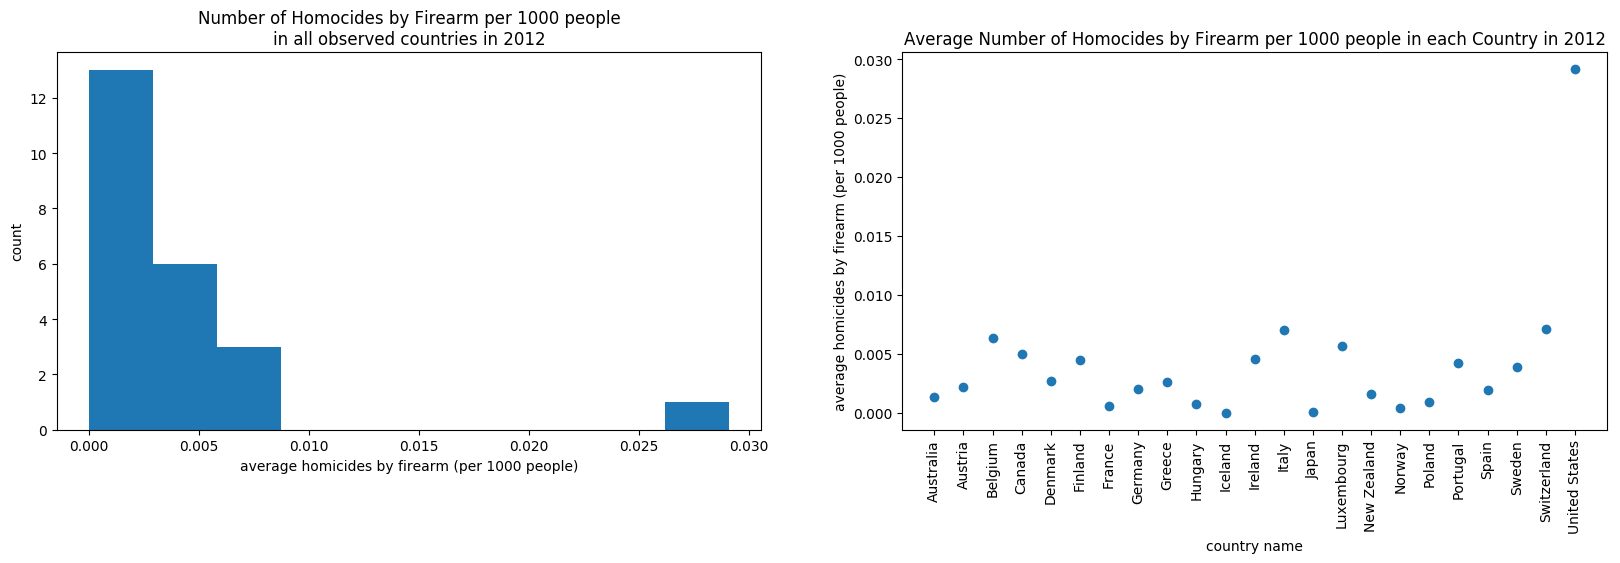

The two figures above are two representations of the same data.
The first graph is a histrogram of the total average number of homocides per 1000 people in all countries observed.
It is clear form the histogram that almost all of the countries show close values between 0 and 0.01 except one outlier that shows a value close to .03.
The second graph comes to calrify that the observed oulier is again the United States.


In [20]:
# histogram / scatter plot

fig, ax = plt.subplots(1, 2, figsize=(20,5), dpi=100)

ax[0].hist(df['Number of homicides by firearm'] / df['pop'] * 1000)
ax[0].set_xlabel('average homicides by firearm (per 1000 people)');
ax[0].set_ylabel('count')
ax[0].set_title('Number of Homocides by Firearm per 1000 people\nin all observed countries in 2012')

ax[1].plot(df['Country Name'], df['Number of homicides by firearm'] / df['pop'] * 1000, linestyle=' ', marker='o')
ax[1].set_xlabel('country name')
ax[1].set_ylabel('average homicides by firearm (per 1000 people)')
ax[1].set_title("Average Number of Homocides by Firearm per 1000 people in each Country in 2012")
plt.xticks(rotation=90)

plt.show()

print(color.BOLD + 'The two figures above are two representations of the same data.\n\
The first graph is a histrogram of the total average number of homocides per 1000 people in all countries observed.\n\
It is clear form the histogram that almost all of the countries show close values between 0 and 0.01 except one outlier \
that shows a value close to .03.\nThe second graph comes to calrify that the observed oulier is again the United States.')

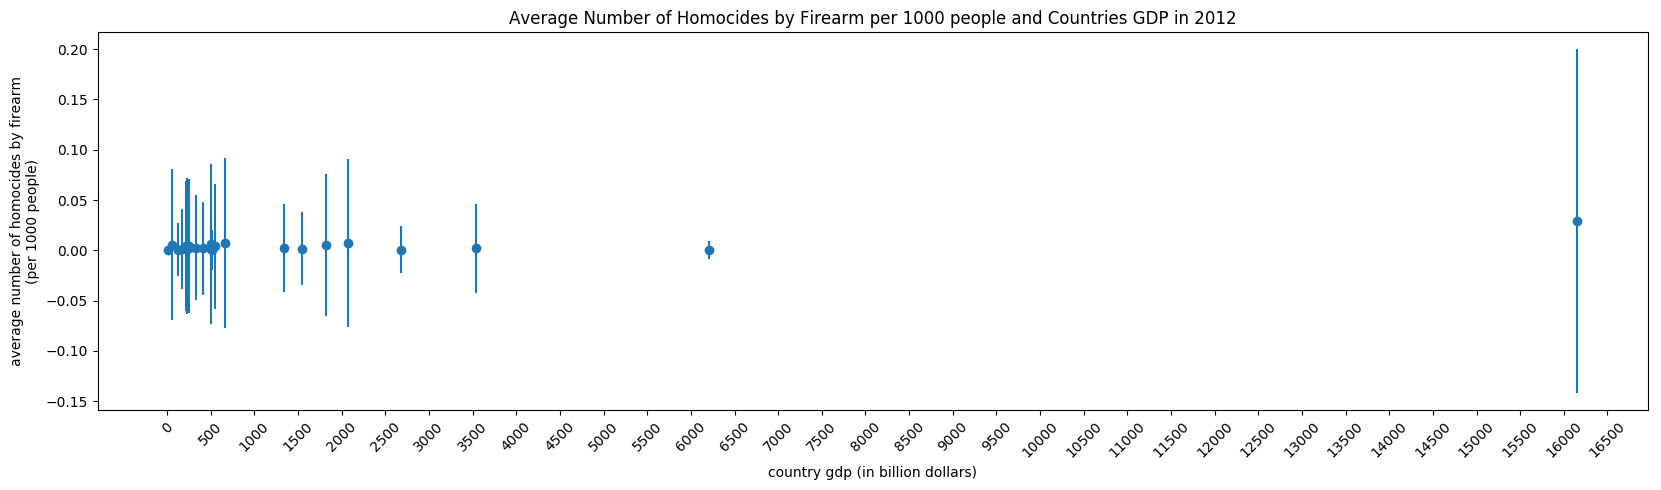

The plot represents the average number of homocides by firearm per 1000 people against each country's gdp, errors represent Poisson statistics.
The United States show the highest gdp and the highest number of homocides.


In [21]:
# against gdp with statistical errors

fig, ax = plt.subplots(figsize=(20,5), dpi=100)

ax.errorbar(df['gdp'] / 1e9, df['Number of homicides by firearm'] / df['pop'] * 1000,\
            yerr=np.sqrt(df['Number of homicides by firearm'] / df['pop'] * 1000), linestyle=' ', marker='o')

ax.set_xlabel('country gdp (in billion dollars)')
ax.set_ylabel('average number of homocides by firearm\n(per 1000 people)')
ax.set_title('Average Number of Homocides by Firearm per 1000 people and Countries GDP in 2012')
plt.xticks(range(0,17000,500), rotation=45)

plt.show()

print(color.BOLD + 'The plot represents the average number of homocides by firearm per 1000 people against each country\'s gdp, errors represent Poisson statistics.\n\
The United States show the highest gdp and the highest number of homocides.')

## 2.4 Plotting the number of  homicides by fire arm against the number of civilian firearms

In [22]:
df.tail(2)

,Country Name,pop,gdp,Number of homicides by firearm,Average total all civilian firearms,Guns/100 inhabitants,Number of mass shootings,average number of civilian fire arms/1000 people
21,Sweden,9519374.0,5.438806e+11,37.0,2800000.0,31.6,2,294.136988
22,United States,313993272.0,1.615526e+13,9146.0,270000000.0,88.8,78,859.891036


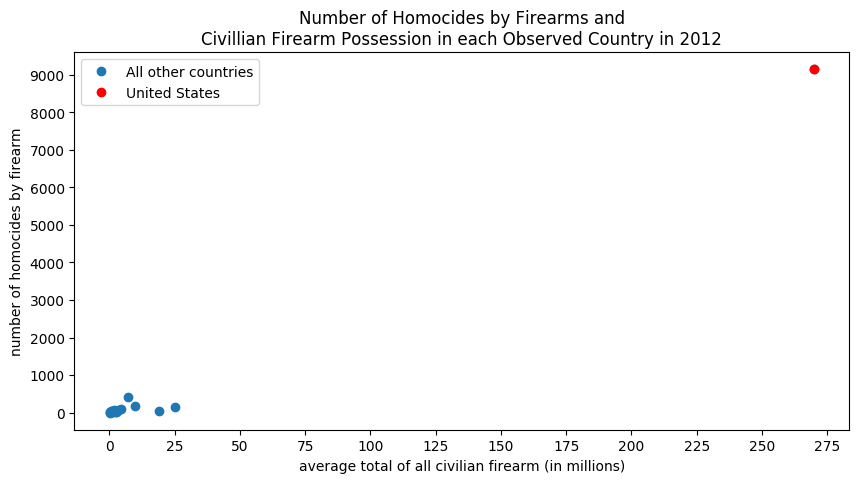

In [23]:
# without errorbars

figure, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(df['Average total all civilian firearms'] / 1e6, df['Number of homicides by firearm'], linestyle=' ', marker='o', label='All other countries')
ax.plot(df['Average total all civilian firearms'][22] / 1e6, df['Number of homicides by firearm'][22], linestyle=' ', marker='o', c='r', label='United States')

ax.set_xlabel('average total of all civilian firearm (in millions)')
ax.set_ylabel('number of homocides by firearm')
ax.set_xticks(range(0,300,25))
ax.set_yticks(range(0,10000,1000))
ax.set_title('Number of Homocides by Firearms and\nCivillian Firearm Possession in each Observed Country in 2012')
plt.legend()



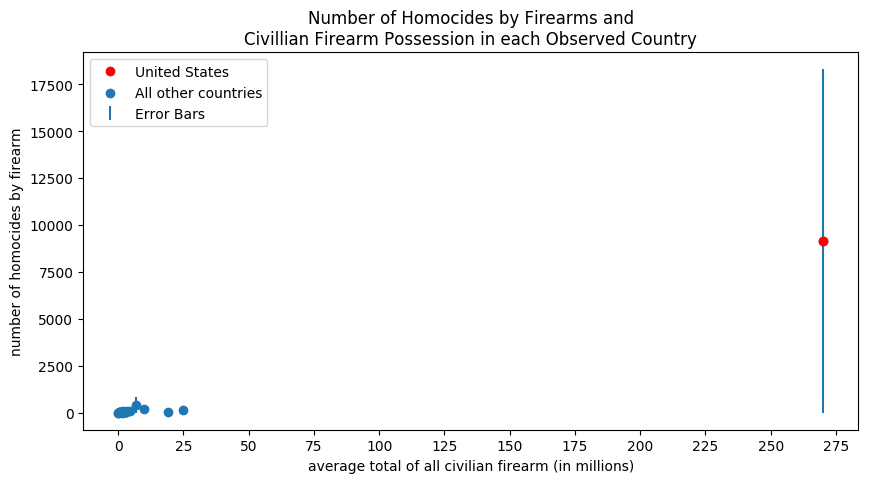

Both scatter plots above represent the number of homocides commited by firearmas a function of the average total of all civillian firearm in each of the countries observed.
The second plot shows error bars. The plots show striking numbers. While all the countries reside in a clustered zone and the very bottom of the plot, the United States shows an extremely high number of firearm possession close to 270 million firearms. The number is accompanied by a very high number of homocides close to 9000.


In [24]:
# with errorbars

figure, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.scatter(df['Average total all civilian firearms'] / 1e6, df['Number of homicides by firearm'],\
           label='All other countries')
ax.plot(df['Average total all civilian firearms'][22] / 1e6, df['Number of homicides by firearm'][22], linestyle=' ', marker='o', c='r', label='United States')
ax.errorbar(df['Average total all civilian firearms'] / 1e6, df['Number of homicides by firearm'],\
            yerr=np.sqrt(df['Number of homicides by firearm'])**2, linestyle=' ', label='Error Bars')

ax.set_xlabel('average total of all civilian firearm (in millions)')
ax.set_ylabel('number of homocides by firearm')
ax.set_xticks(range(0,300,25))
ax.get_ylim()
ax.set_title('Number of Homocides by Firearms and\nCivillian Firearm Possession in each Observed Country')
plt.legend(loc=2)

plt.show()

print(color.BOLD + 'Both scatter plots above represent the number of homocides commited by firearm\
as a function of the average total of all civillian firearm in each of the countries observed.\n\
The second plot shows error bars. \
The plots show striking numbers. While all the countries reside in a clustered zone and the very bottom of the plot, \
the United States shows an extremely high number of firearm possession close to 270 million firearms. \
The number is accompanied by a very high number of homocides close to 9000.')

## 2.5 Plotting the number of mass shootings against the number of civilian firearms

In [25]:
df.tail()

,Country Name,pop,gdp,Number of homicides by firearm,Average total all civilian firearms,Guns/100 inhabitants,Number of mass shootings,average number of civilian fire arms/1000 people
18,New Zealand,4408100.0,1.761929e+11,7.0,925000.0,22.6,3,209.840975
19,Poland,38063164.0,5.003608e+11,35.0,510000.0,1.3,0,13.398781
20,Portugal,10514844.0,2.163682e+11,44.0,900000.0,8.5,1,85.593281
21,Sweden,9519374.0,5.438806e+11,37.0,2800000.0,31.6,2,294.136988
22,United States,313993272.0,1.615526e+13,9146.0,270000000.0,88.8,78,859.891036


In [26]:
df['shootingsp1000p'] = df["Number of mass shootings"] / df['pop'] * 1e3

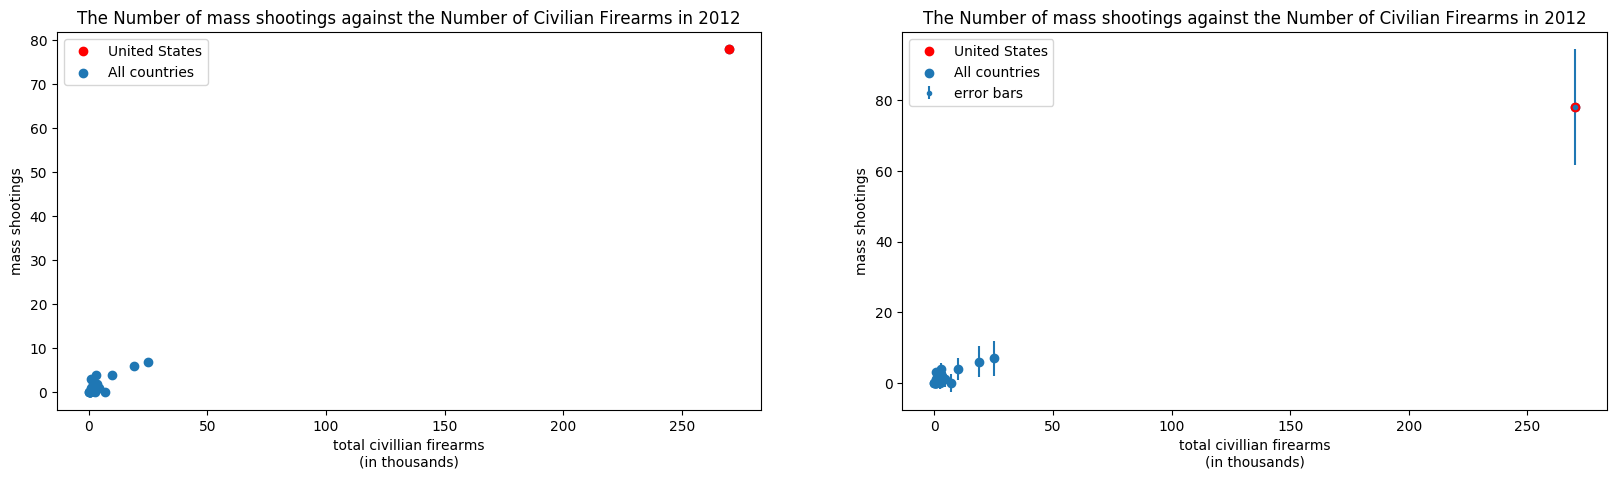

The two plots are for the number of mass shooting against the total number of civillian firearms in 2012.
The second figure is plottes with error bars. The United States is shown as an outlier here as well.
The US has a total number of cvillian firearms equal to 270 thousands with a 78 cases of mass shootings.
The rest of the countries show a very low values for the studied variables if compared to the US


In [27]:
# without error

fig, ax = plt.subplots(1, 2, figsize=(20,5), dpi=100)

ax[0].scatter(df['Average total all civilian firearms'] / 1e6, df['Number of mass shootings'], label='All countries')
ax[0].plot(df['Average total all civilian firearms'][22] / 1e6, df['Number of mass shootings'][22], linestyle=' ', marker='o', c='r', label='United States')

ax[0].set_ylabel('mass shootings')
ax[0].set_xlabel('total civillian firearms\n(in thousands)')
ax[0].set_title('The Number of mass shootings against the Number of Civilian Firearms in 2012')
ax[0].legend(loc=2)

ax[1].scatter(df['Average total all civilian firearms'] / 1e6, df['Number of mass shootings'], label='All countries')
ax[1].plot(df['Average total all civilian firearms'][22] / 1e6, df['Number of mass shootings'][22], linestyle=' ', marker='o', c='r', label='United States')
ax[1].errorbar(df['Average total all civilian firearms'] / 1e6, df['Number of mass shootings'], label='error bars',\
              yerr=np.sqrt(df['Average total all civilian firearms'] / 1e6), fmt='.')

ax[1].set_ylabel('mass shootings')
ax[1].set_xlabel('total civillian firearms\n(in thousands)')
ax[1].set_title('The Number of mass shootings against the Number of Civilian Firearms in 2012')
ax[1].get_ylim()
plt.legend(loc=2)

plt.show()
print(color.BOLD + 'The two plots are for the number of mass shooting against the total number of civillian firearms in 2012.\n\
The second figure is plottes with error bars. The United States is shown as an outlier here as well.\n\
The US has a total number of cvillian firearms equal to 270 thousands with a 78 cases of mass shootings.\n\
The rest of the countries show a very low values for the studied variables if compared to the US')

# 3. Modeling

### 3.1 Optimizing by Numpy

In [28]:
# define the general model as a function
def model(x, a0=3, a1=2, a2=0):
    return a0 + (a1*x) + (a2*x**2)

# define a function for plotting data and model
def plot_data_with_model(x, y, ym, xlabel, ylabel, title):
    fig, ax = plt.subplots(dpi=100)
    ax.plot(x, y, linestyle=" ", marker="o", color="black", label="Measured")
    ax.plot(x, ym, linestyle="-", marker=None, color="red", label="Modeled")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.legend(loc="best")
    plt.show()
    return fig, ax

# define a function to compute RSS value
def compute_rss(y, ym):
    rss = np.sum(np.square(ym - y))
    return rss

# define a function to compute RSS, build a model and plot
def comp_rss_and_plot_fit(x, y, a0, a1, xlabel, ylabel, title):
    ym = model(x, a0, a1)
    rss = compute_rss(y, ym)
    summary = 'Parameters a0 = {}, a1 = {}, yield RSS = {:0.2f}'.format(a0, a1, rss)
    fig = plot_data_with_model(x, y, ym, xlabel, ylabel, title)
    return fig, summary
    

In [29]:
# mass shootings per person
df['masspp'] = df['Number of mass shootings'] / df['pop']
df['masspp'].head()

0    1.758824e-07
1    1.186241e-07
2    1.797228e-07
3    1.151061e-07
4    2.500981e-07
Name: masspp, dtype: float64

In [30]:
# average total of all civillian firearms per person
df['fapp'] = df['Average total all civilian firearms'] / df['pop']
df['fapp'].head()

0    0.134110
1    0.296560
2    0.161751
3    0.286326
4    0.425167
Name: fapp, dtype: float64

In [31]:
# getting the order of the mean of the sample
df['masspp'].mean()

1.2356888832925394e-07

In [32]:
# dividing by the order of magnitude to insure unity
df['masspp'] = df['masspp'] * 1e7
df['masspp'].head()

0    1.758824
1    1.186241
2    1.797228
3    1.151061
4    2.500981
Name: masspp, dtype: float64

In [33]:
x = df['fapp']
y = df['masspp']

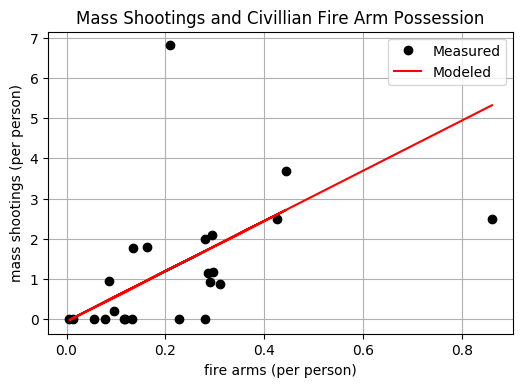

((<matplotlib.figure.Figure at 0x7f3220ba6e48>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f3220cb9cf8>),
 'Parameters a0 = -0.0534, a1 = 6.2489, yield RSS = 50.96')

In [34]:
comp_rss_and_plot_fit(x, y, -0.0534, 6.2489, xlabel='fire arms (per person)',\
                      ylabel='mass shootings (per person)',\
                      title='Mass Shootings and Civillian Fire Arm Possession')

### 3.2 Optimizing by Scipy

In [35]:
def model_func(x, a0, a1):
    return a0 + a1*x

param_opt, param_cov = optimize.curve_fit(model_func, x, y)

print(param_opt)
print('\n')
print(param_cov)

[ 0.36839732  3.8373025 ]


[[ 0.24683415 -0.6681924 ]
 [-0.6681924   2.95639484]]


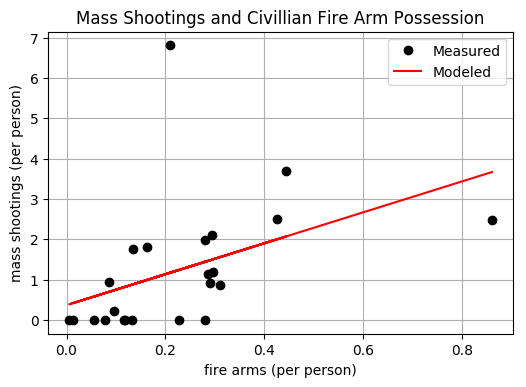

In [36]:
a0 = param_opt[0]
a1 = param_opt[1]

fig_scipy, rss = comp_rss_and_plot_fit(x, y, a0, a1, xlabel='fire arms (per person)',\
                      ylabel='mass shootings (per person)',\
                      title='Mass Shootings and Civillian Fire Arm Possession')

### 3.3 Optimizing by Statsmodels OLS and WLS

In [37]:
# using add_constant

X = sm.add_constant(df['fapp'])
sm_ols = smf.OLS(y, X).fit()
sm_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 masspp   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     4.981
Date:                Mon, 25 Feb 2019   Prob (F-statistic):             0.0367
Time:                        17:35:08   Log-Likelihood:                -40.676
No. Observations:                  23   AIC:                             85.35
Df Residuals:                      21   BIC:                             87.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3684      0.497      0.742      0.467        -0.665     1.402
fapp           3.8373      1.719      2.232      0.037         0.262     7.413
==============================================================================
Omnibus:                       34.558   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.760
Skew:                           2.666   Prob(JB):                     5.32e-20
Kurtosis:                      11.012   Cond. No.                         5.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# using statsmodels.formula.api

ols_model_fit = ols(formula='y ~ x', data=df).fit()
ols_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     4.981
Date:                Mon, 25 Feb 2019   Prob (F-statistic):             0.0367
Time:                        17:35:08   Log-Likelihood:                -40.676
No. Observations:                  23   AIC:                             85.35
Df Residuals:                      21   BIC:                             87.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3684      0.497      0.742      0.467        -0.665     1.402
x              3.8373      1.719      2.232      0.037         0.262     7.413
==============================================================================
Omnibus:                       34.558   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.760
Skew:                           2.666   Prob(JB):                     5.32e-20
Kurtosis:                      11.012   Cond. No.                         5.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Both ols statsmodels function give the same result

In [39]:
ols_model_fit.params

Intercept    0.368397
x            3.837303
dtype: float64

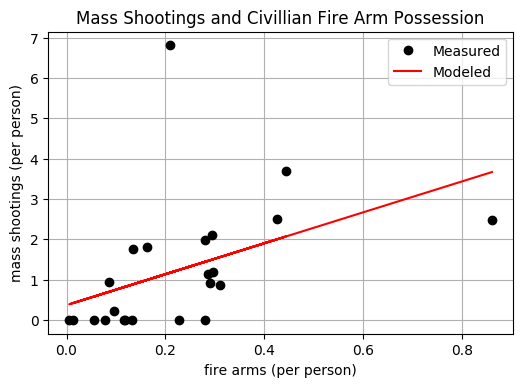

((<matplotlib.figure.Figure at 0x7f3220a81198>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f3220a817b8>),
 'Parameters a0 = 0.36839728572040753, a1 = 3.8373025804348857, yield RSS = 46.28')

In [40]:
# plotting the ols fit

a0 = ols_model_fit.params['Intercept']
a1 = ols_model_fit.params['x']

comp_rss_and_plot_fit(x, y, a0, a1, xlabel='fire arms (per person)',\
                      ylabel='mass shootings (per person)',\
                      title='Mass Shootings and Civillian Fire Arm Possession')

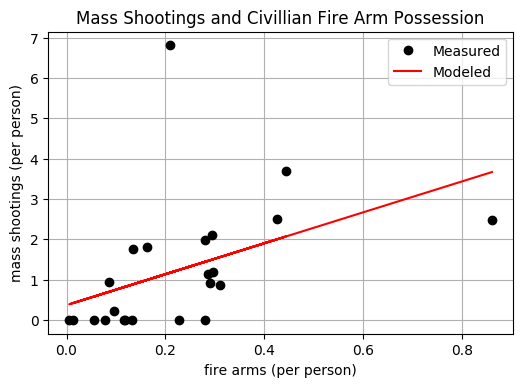

(<matplotlib.figure.Figure at 0x7f3220a78e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3220a8af60>)

In [41]:
# or calulating ym throught the predict()
# and using the plot_data_with_model function instead to plot

ym = ols_model_fit.predict(df)

plot_data_with_model(x, y, ym, xlabel='fire arms (per person)',\
                      ylabel='mass shootings (per person)',\
                      title='Mass Shootings and Civillian Fire Arm Possession')


In [42]:
# WLS

# errors show zero numbers. knowing that we cannot divide by 0 
# I took the minimum error above zero and assigned it instead of zeros 


min_error = np.sqrt(df['masspp'])[np.sqrt(df['masspp']) > 0].min()
df['mass_error'] = np.sqrt(df['masspp'])
df['mass_error'].replace(0, min_error, inplace=True)
df['mass_error']

0     1.326206
1     1.089147
2     1.340607
3     1.072875
4     1.581449
5     0.932935
6     0.462383
7     0.462383
8     1.922016
9     0.955930
10    0.462383
11    0.462383
12    0.462383
13    0.462383
14    0.462383
15    0.462383
16    0.462383
17    1.411594
18    2.608765
19    0.462383
20    0.975211
21    1.449475
22    1.576112
Name: mass_error, dtype: float64

In [43]:
sm_wls = smf.WLS(y, X, weights=list(1/df['mass_error'])).fit()
sm_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 masspp   R-squared:                       0.293
Model:                            WLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     8.699
Date:                Mon, 25 Feb 2019   Prob (F-statistic):            0.00766
Time:                        17:35:09   Log-Likelihood:                -32.338
No. Observations:                  23   AIC:                             68.68
Df Residuals:                      21   BIC:                             70.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0940      0.306     -0.307      0.762        -0.730     0.543
fapp           3.9869      1.352      2.949      0.008         1.176     6.798
==============================================================================
Omnibus:                       15.781   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.892
Skew:                           1.433   Prob(JB):                     0.000130
Kurtosis:                       6.234   Cond. No.                         6.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


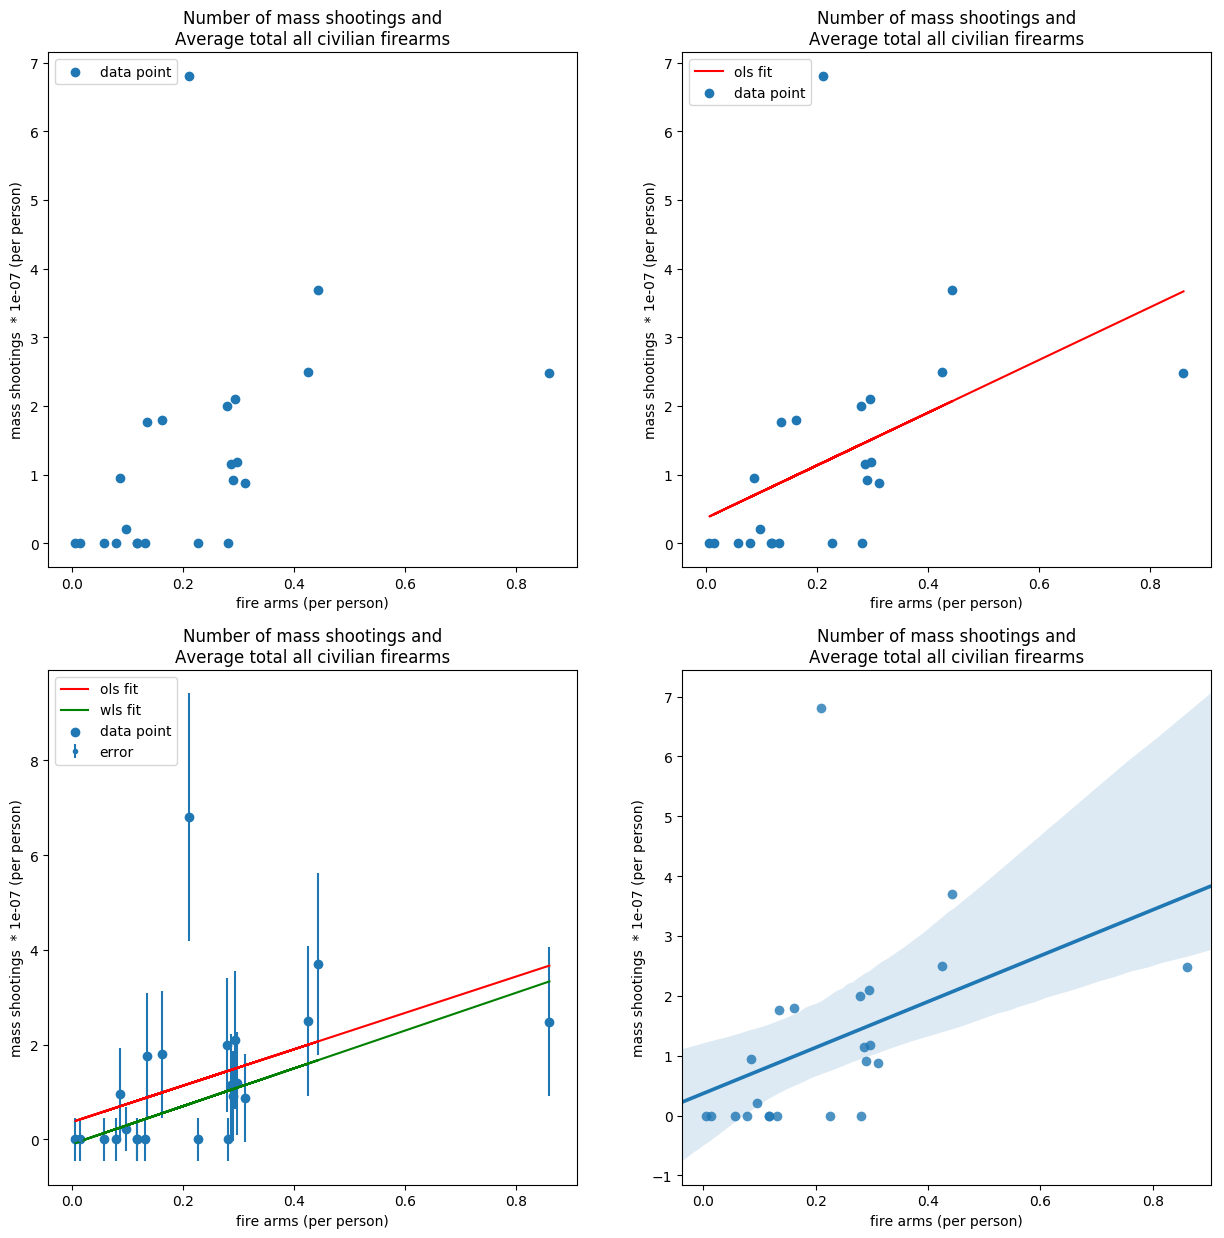

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(15,15), dpi=100)

ax[0,0].scatter(df['fapp'], df['masspp'], label='data point')
ax[0,0].set_xlabel('fire arms (per person)')
ax[0,0].set_ylabel('mass shootings  * {} (per person)'.format(10**-7))
ax[0,0].set_title('Number of mass shootings and\nAverage total all civilian firearms')
ax[0,0].legend(loc=2)

ax[0,1].scatter(df['fapp'], df['masspp'], label='data point')
ax[0,1].plot(x, sm_ols.fittedvalues, 'r', label='ols fit')
ax[0,1].set_xlabel('fire arms (per person)')
ax[0,1].set_ylabel('mass shootings  * {} (per person)'.format(10**-7))
ax[0,1].set_title('Number of mass shootings and\nAverage total all civilian firearms')
ax[0,1].legend(loc=2)

ax[1,0].scatter(df['fapp'], df['masspp'], label='data point')
ax[1,0].errorbar(df['fapp'], df['masspp'], yerr=df['mass_error'], fmt='.', label='error')
ax[1,0].plot(x, sm_ols.fittedvalues, 'r', label='ols fit')
ax[1,0].plot(x, sm_wls.fittedvalues, 'g', label='wls fit')
ax[1,0].set_xlabel('fire arms (per person)')
ax[1,0].set_ylabel('mass shootings  * {} (per person)'.format(10**-7))
ax[1,0].set_title('Number of mass shootings and\nAverage total all civilian firearms')
ax[1,0].legend(loc=2)

import seaborn as sns  # i imported seaborn here at the end cause i don't want it to ruin my plots!

ax[1,1].sns_reg = sns.regplot(x, y, data=df)
ax[1,1].set_xlabel('fire arms (per person)')
ax[1,1].set_ylabel('mass shootings  * {} (per person)'.format(10**-7))
ax[1,1].set_title('Number of mass shootings and\nAverage total all civilian firearms')
ax[1,1].legend(loc=2)



**The plots above show the number of mass shootings per person in the observed countries plotted againt fire arm possession per person in 2012. Outliers were removed before starting the regression. From the exploratory analysis doen before it was clear that the US is an outlier so it was dropped. Then the data point were fitted using different models. We can observe a slightly different linear fits resulting from each model. The models show a positive linear relation, however the regression results show a low value of r-squared.**

## 3.4 Calculating the confidence interval by hand

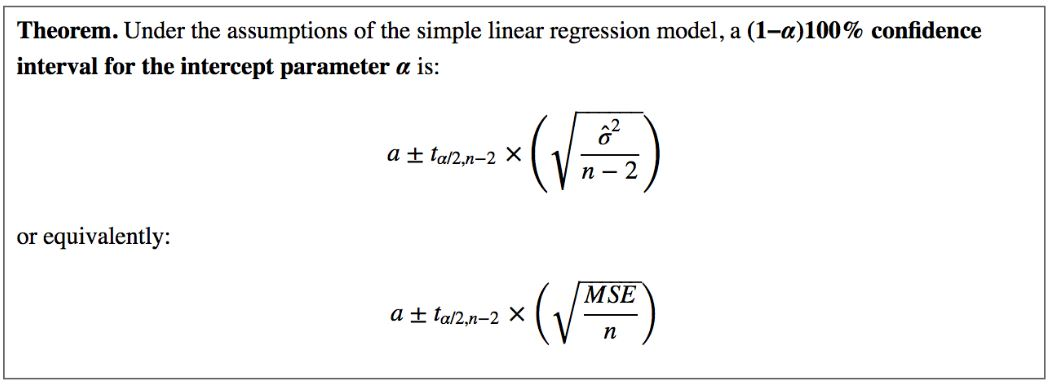

In [45]:
Image(filename='images/CI_.JPG')

In [46]:
#ci_95 = np.percentile(ym, [2.5, 97.5])
# for alpha=0.5
# Define t_alpha/2,n-2 the t statistics at (1-alpha/2) for a t distribution with n-2 degrees of freedom 


n = len(x)
tp = sp.stats.t.ppf(0.975, n-2)
sigma_hat= np.sqrt((np.sum(x - ym) ** 2) / n)
ci = tp * (np.sqrt(sigma_hat ** 2 / (n -2)))

print('t-statistic at (1-alpha/2) = {}\nConfidence Interval = +/-{}'.format(tp, ci))

t-statistic at (1-alpha/2) = 2.079613844727662
Confidence Interval = +/-2.19744332937188


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


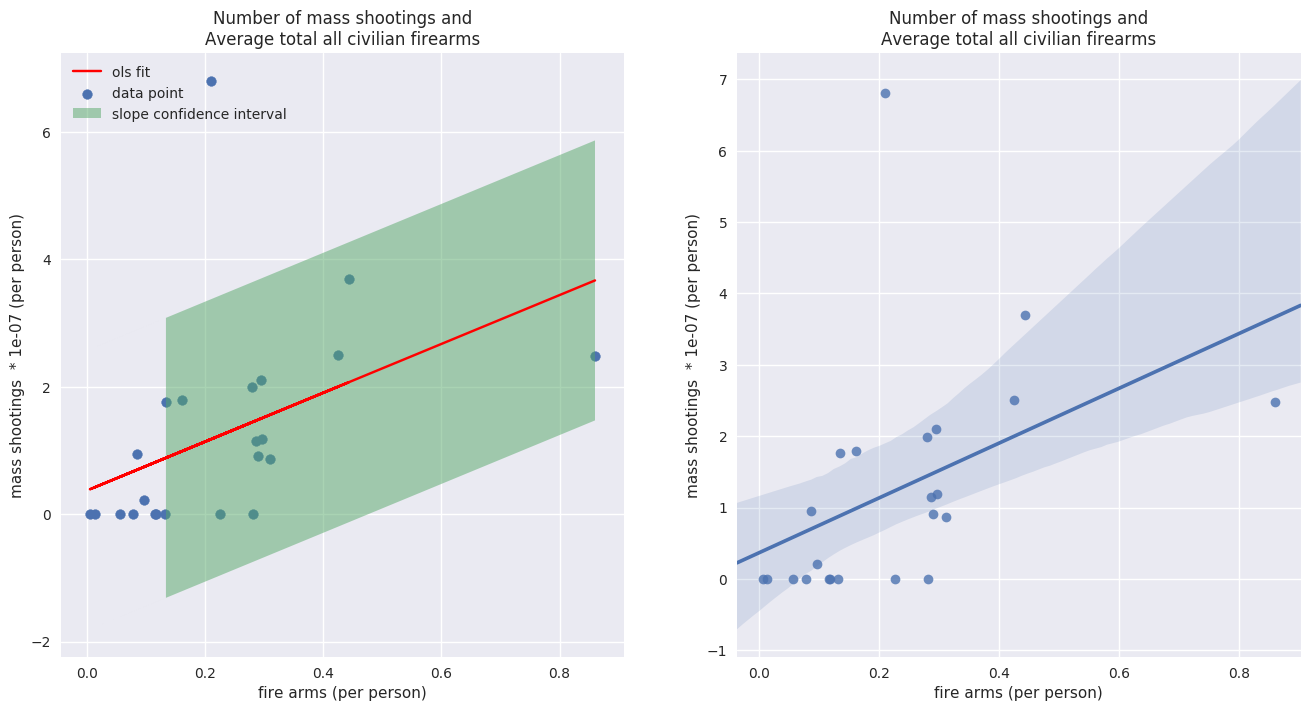

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16,8), dpi=100)

# ols fitted values with confidence interval
ax[0].scatter(df['fapp'], df['masspp'], label='data point')
ax[0].plot(x, sm_ols.fittedvalues, 'r', label='ols fit')
ax[0].set_xlabel('fire arms (per person)')
ax[0].set_ylabel('mass shootings  * {} (per person)'.format(10**-7))
ax[0].set_title('Number of mass shootings and\nAverage total all civilian firearms')
ax[0].fill_between(x, sm_ols.fittedvalues - ci, sm_ols.fittedvalues + ci, alpha=0.5, label='slope confidence interval')
ax[0].legend(loc=2)

# using sns
sns.regplot(x, y, data=df, ax=ax[1])
ax[1].set_xlabel('fire arms (per person)')
ax[1].set_ylabel('mass shootings  * {} (per person)'.format(10**-7))
ax[1].set_title('Number of mass shootings and\nAverage total all civilian firearms')
ax[1].legend(loc=2)

** the confidence intervals produced by the two different methods are not same. the sns plot tends to show a better representation of the confidence interval. the latter shows a large interval plotted to the right closed to the observed data point which is the United States confirming the idea of high uncertainty around the predictions done at this domain which could outside of the models domain of validity.**

## 3.5 Influence plot

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


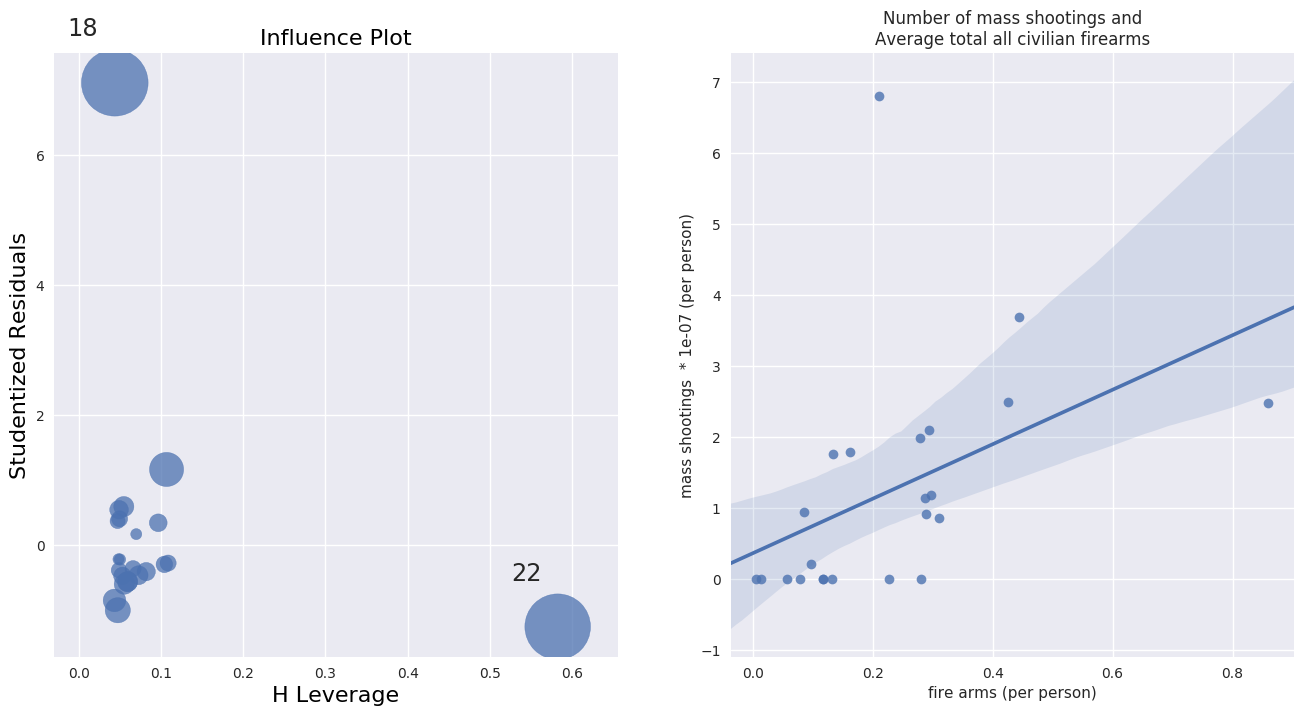

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(16,8), dpi=100)

sm.graphics.influence_plot(sm_ols, alpha  = 0.05, criterion="cooks", ax=ax[0]);

# using sns
ax[1].sns_reg = sns.regplot(x, y, data=df)
ax[1].set_xlabel('fire arms (per person)')
ax[1].set_ylabel('mass shootings  * {} (per person)'.format(10**-7))
ax[1].set_title('Number of mass shootings and\nAverage total all civilian firearms')
ax[1].legend(loc=2)

** A plot of residuals as a function of leverage identifies influential observations that are not modeled well by the regression. These quantities are shown here for the fit results of the ols model. The criterion is set to 'Cooks', and size of the points represent cooks distance. The 18th observation (New Zealand) stands out as a low-leverage outlier with a large residual and a large Cook’s distance. In contrast, the 22th observation (United States) has high leverage, a large residual and a large Cook’s distance. It is good to note that observations near the mean have less influence on the regression estimates and fitted values. **

In [49]:
df['Country Name'][18]

'New Zealand'

In [50]:
df['Country Name'][22]

'United States'